# Environment Set Up

The code below downloads the relevant `skpro` development branch from github and install it.

It also "corrects" the version of `pymc` that comes pre-installed on Google Colab.

Note: after running the above cell, remember to restart the session for the changes to take effect.

# Introduction

In [273]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skpro.regression.bayesian_prior_class import BayesianLinearRegressor

In [274]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook serves to demonstrate the use of the `skpro`'s `BayesianLinearRegressor` regressor. This class implements Bayesian linear regression using `PyMC` as a backend. It assumes weakly-informative Bayesian priors for both the intercepts and slopes of the model.

Compared to a traditional OLS Linear Regression,  Bayesian Linear Regression offers several benefits:

1. It provides full posterior distributions of model parameters, allowing for direct assessment of uncertainty in predictions.
2. It enables the inclusion of prior information or beliefs about parameters, improving estimates when data is limited.
3. It regularizes parameter estimates through priors, reducing overfitting compared to traditional linear regression.


## Data Generation

We will first create synthetic data with just one feature (`feature1`) and 50 data points. The true relationship between the data $\mathbf{x}$ and the target variable ($y_{\text{true}}$) is given by the equation:

\begin{equation}
y_{\text{true}} = \text{intercept}_{\text{true}} + \mathbf{x} \cdot \mathbf{m}_{\text{true}}
\end{equation}


where $\text{intercept}_{\text{true}} = 1$ and $\mathbf{m}_{\text{true}} = 2$.

The observed target values ($y_{\text{train}}$) are generated by adding Gaussian noise to the true target values:

\begin{equation}
y = y_{\text{true}} + \mathcal{N}(0, \sigma_{\text{true}})
\end{equation}
Here, $\sigma_{\text{true}} = 0.5$.


In [275]:
N = 50
np.random.seed(42)
# Creating 50 random data points containing 1 feature
feature1 = np.random.uniform(0, 1, N)
X_train = pd.DataFrame({"feature1": feature1})

# Set the relationship between the feature and the target variable
TRUE_INTERCEPT = 1
TRUE_SLOPES = np.array([2])
TRUE_SIGMA = 0.5

# Calculating the true target variable
y_true = TRUE_INTERCEPT + np.dot(X_train, TRUE_SLOPES)
y_train = y_true + np.random.normal(0, TRUE_SIGMA, size=len(X_train))

# Combine the features and targets into a single DataFrame
train_data = pd.concat(
    [X_train, pd.Series(y_true, name="y_true"), pd.Series(y_train, name="y_train")],
    axis=1,
)
train_data = train_data.sort_values(by="feature1")
train_data = train_data.reset_index(drop=True)

# Display the train_data DataFrame
train_data.head()

,feature1,y_true,y_train
0,0.020584,1.041169,1.203211
1,0.034389,1.068777,1.807724
2,0.046450,1.092901,0.770341
3,0.058084,1.116167,0.885848
4,0.065052,1.130103,1.112190


The line chart below plots the relationship between `feature1` and the targets - both the theoretical `y_true`, represented by the red line, and the observed `y_train`, represented by the blue dots.

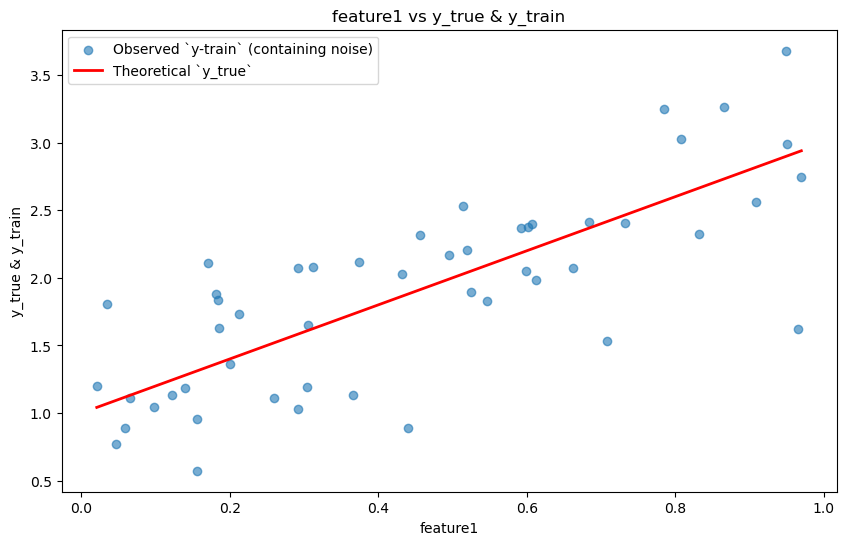

In [276]:
# Plot feature1 vs true_target
plt.figure(figsize=(10, 6))
plt.scatter(
    train_data["feature1"],
    train_data["y_train"],
    label="Observed `y-train` (containing noise)",
    alpha=0.6,
)
plt.plot(
    train_data["feature1"],
    train_data["y_true"],
    color="red",
    label="Theoretical `y_true`",
    linewidth=2,
)
plt.xlabel("feature1")
plt.ylabel("y_true & y_train")
plt.title("feature1 vs y_true & y_train")
plt.legend()
plt.show()

We will also create synthetic testing data to evaluate the models' performance on new, unseen data points. The following code generates 30 new testing data points.

In [277]:
# Generate new data points for prediction
N_test = 30
X_test = pd.DataFrame({"feature1": np.linspace(0, 1, N_test)})
X_test.head()

,feature1
0,0.000000
1,0.034483
2,0.068966
3,0.103448
4,0.137931


# OLS

To determine the relationship between the features and the target variable, we will train and inspect a model.

First, we'll train an Ordinary Least Squares (OLS) regression model using the `statsmodels` library.

In [278]:
import statsmodels.api as sm

# Fit a linear regression model using statsmodels
X_train_with_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_with_const).fit()

When fitted to the data, the `ols_model` above use maximum likelihood to find estimates of the model parameters. A downside of this approach is that it only gives point estimates - that is, single values for the slope and intercept without providing information about the distribution of these estimates.


The code below shows how we can extract out the estimated parameters from `ols_model`. As we can see, the point estimates for the slopes, intercept, and standard deviation are quite close to the true values we set earlier.

In [279]:
y_train_pred = ols_model.predict(X_train_with_const)
residuals = y_train_pred - y_train

# Print the true model and estimated model
print("True data generating model:")
print(f"y_true = {TRUE_SLOPES[0]:.2f}x + {TRUE_INTERCEPT:.2f}")
print(f"True standard deviation: {TRUE_SIGMA}\n")

print("Estimated MLE model:")
print(f"y_hat = {ols_model.params.iloc[1]:.2f}x + {ols_model.params.iloc[0]:.2f}")
print(f"Standard deviation of residuals: {residuals.std():.2f}")

True data generating model:
y_true = 2.00x + 1.00
True standard deviation: 0.5

Estimated MLE model:
y_hat = 1.89x + 1.05
Standard deviation of residuals: 0.46



Using the trained `ols_model`,  we can also create point predictions on the unseen `X_test` along with the corresponding confidence interval. The latter provides a range within which we expect the true parameter to lie with a certain level of confidence (e.g., 95%).

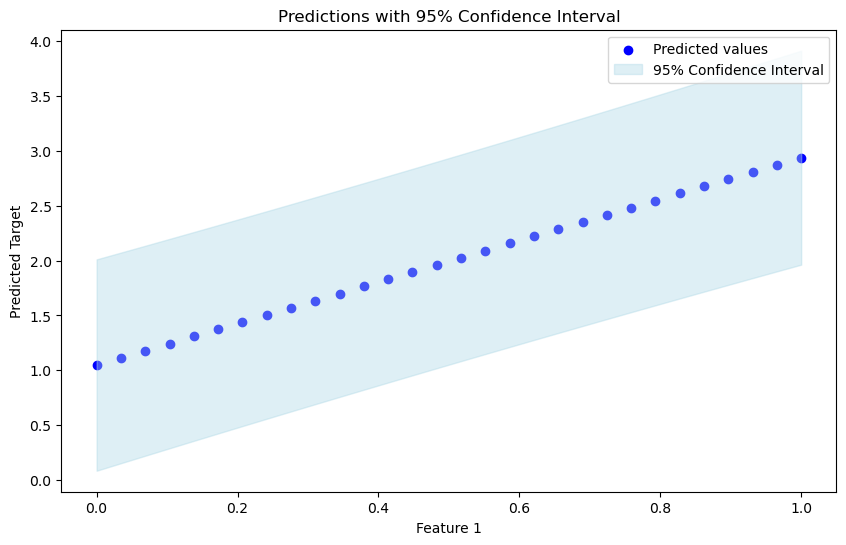

In [280]:
# Predict y_test using the linear model
X_test_with_const = sm.add_constant(X_test)
predictions = ols_model.get_prediction(X_test_with_const)
pred_summary = predictions.summary_frame(alpha=0.05)

# Extract predicted values and confidence intervals
y_test_pred = pred_summary["mean"]
conf_int_lower = pred_summary["obs_ci_lower"]
conf_int_upper = pred_summary["obs_ci_upper"]

# Plot the predictions with the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test["feature1"], y_test_pred, color="blue", label="Predicted values")
plt.fill_between(
    X_test["feature1"],
    conf_int_lower,
    conf_int_upper,
    color="lightblue",
    alpha=0.4,
    label="95% Confidence Interval",
)
plt.xlabel("Feature 1")
plt.ylabel("Predicted Target")
plt.title("Predictions with 95% Confidence Interval")
plt.legend()
plt.show()

# Bayesian Inference

Now let's switch our attention to bayesian linear regression. Bayesian linear regression estimates the relationship between variables by incorporating prior knowledge or beliefs along with the observed data. Instead of providing single point estimates for the model parameters (like the slope and intercept), it calculates their probability distributions.

`skpro` provides an implementation of Bayesian linear regression through the `BayesianLinearRegressor` class. Here, we create an instance of the `BayesianLinearRegressor` and fit it to our training data.

In [281]:
y_train = pd.DataFrame(y_train)
y_train.columns = ["target"]

In [282]:
bayes_model = BayesianLinearRegressor()
bayes_model.default_prior_config

{'intercept': Prior("Normal", mu=0, sigma=10),
 'slopes': Prior("Normal", mu=0, sigma=10, dims="pred_id"),
 'noise_var': Prior("InverseGamma", alpha=1, beta=1)}

In [283]:
%timeit
bayes_model.fit(X_train, y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=0, sigma=10),
                                      'noise_var': Prior("InverseGamma", alpha=1, beta=1),
                                      'slopes': Prior("Normal", mu=0, sigma=10, dims="pred_id")},
                        sampler_config={'chains': 1, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

## Theory

In this section, we will explore the theoretical framework used in Bayesian linear regression.

Bayesian linear regression directly applies Bayes' Theorem to estimate the posterior distributions of the model parameters. As a reminder, here is the Bayes Theorem:

\begin{align*}
P(\theta \mid D) &= \frac{P(D \mid \theta) \times P(\theta)}{P(D)} \\
\text{posterior} &= \frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}}
\end{align*}


Where:

- $\theta$ represents the model parameters, which in our case consist of the intercept $\beta_{0}$, the slopes $\beta$ and the noise $\sigma$
- $D$ represents the observed training data, which consist of $\mathbf{X}_{\text{train}}$ and  $\mathbf{y}_{\text{train}}$
- $P(\theta \mid D)$ is the posterior distribution of the parameters - given the data.
- $P(D \mid \theta)$ is the likelihood of the data given the parameters.
- $P(\theta)$ is the prior distribution of the parameters.
- $P(D)$ is the marginal likelihood (evidence), a normalizing constant ensuring the posterior is a valid probability distribution.



### Prior

The prior $P(\theta)$ reflects our beliefs about the parameters before observing any data. In our case, since we don't have any strong beliefs about the parameters, we shall use weekly informative priors for our parameters:

\begin{align*}
\text{intercept} &== \beta_{0} &\sim \mathcal{N}(0, 10) \\
\text{slopes} &== \beta &\sim \mathcal{N}(0, 10) \\
\text{noise} &== \sigma &\sim \text{HalfNormal}(10)
\end{align*}


These priors are specified when we instantiate our model: `BayesianLinearRegressor(intercept_mu=0, intercept_sigma=10,
                                      slopes_mu=0, slopes_sigma=10,
                                      noise_sigma=10)`

We can extract the prior through the `sample_prior` method of the `bayes_model`. We see that these prior distributions match the distributions we set during model instantiation.

Sampling: [intercept, noise_var, slopes, y_obs]


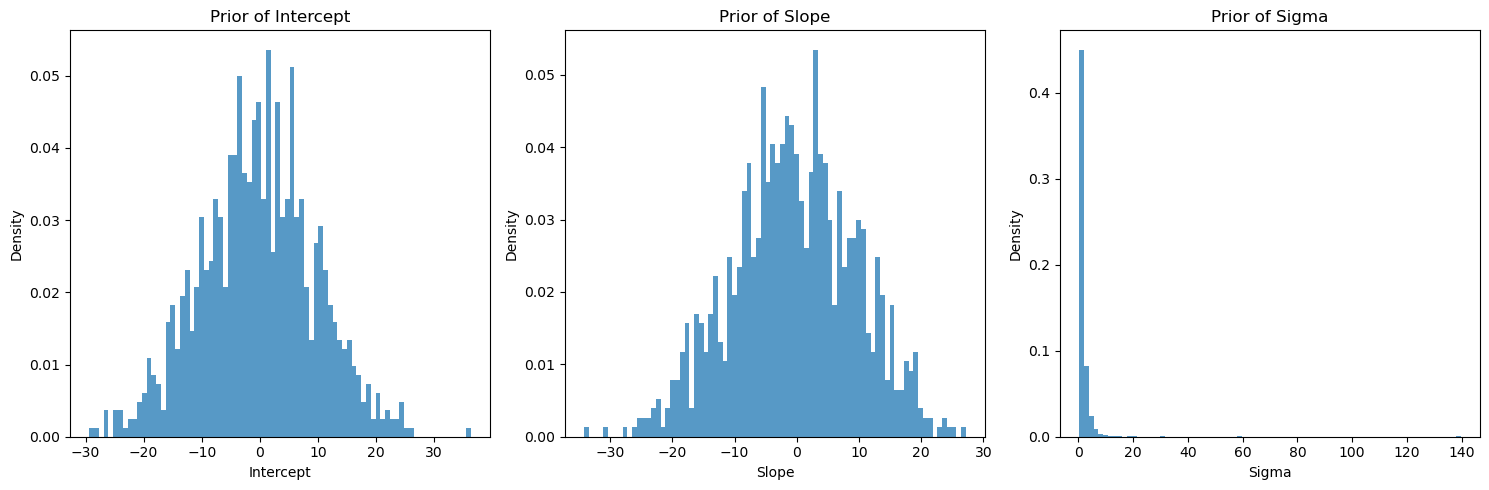

In [284]:
# get the prior samples as a dictionary of numpy arrays
prior_samples = bayes_model.sample_prior("numpy")

# Plot the prior distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot prior for intercept
axes[0].hist(prior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].set_title("Prior of Intercept")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")

# Plot prior for slope
axes[1].hist(prior_samples["slopes"], bins=80, density=True, alpha=0.75)
axes[1].set_title("Prior of Slope")
axes[1].set_xlabel("Slope")
axes[1].set_ylabel("Density")

# Plot prior for sigma
axes[2].hist(prior_samples["noise"], bins=80, density=True, alpha=0.75)
axes[2].set_title("Prior of Sigma")
axes[2].set_xlabel("Sigma")
axes[2].set_ylabel("Density")

plt.tight_layout()
plt.show()

Note that `sample_prior`can give us multiple return types. We can also get our samples back as an `skpro` distribution.

In [285]:
prior_samples = bayes_model.sample_prior("skpro")
prior_samples

Sampling: [intercept, noise_var, slopes, y_obs]


Empirical(columns=Index(['value'], dtype='object'),
          index=Index(['intercept', 'slopes', 'noise_var', 'noise'], dtype='object', name='variable'),
          spl=                      value
obs_id variable            
0      intercept  10.755188
       slopes     -5.347675
       noise_var   1.958837
       noise       1.399585
1      intercept  -4.972449
...                     ...
998    noise       0.809853
999    intercept  -2.045054
       slopes     16.852311
       noise_var   0.938735
       noise       0.968883

[4000 rows x 1 columns])

In [286]:
bayes_model.get_prior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.316,9.804,-19.315,17.211,0.301,0.234,1057.0,912.0,NaN
slopes[feature1],-0.482,9.877,-19.121,17.667,0.318,0.225,964.0,970.0,NaN
noise_var,29.640,628.224,0.144,17.089,19.801,14.022,1097.0,1033.0,NaN
noise,1.909,5.101,0.380,4.134,0.158,0.114,1097.0,1033.0,NaN


Note that, choosing the correct priors is crucial because priors influence the posterior distribution, especially with limited data. Poorly chosen priors can distort the posterior, resulting in misleading inferences and predictions.

In the subsequent section, we will look at "prior predictive checks" that we can use to sanity check our chosen priors.

## Likelihood



The likelihood function $P(D \mid \theta)$ represents how likely it is to observe the given data, $D$, given a set of parameters $\theta$.

For linear regression, we are assume that each observed data point $y_i$ is normally distributed around its predicted value $\beta_0 + X_i \beta$, with variance $\sigma^2$.
    
$$P(D \mid \beta, \sigma) = \prod_{i=1}^{n} \mathcal{N}(y_i \mid \beta_0 + X_i \beta, \sigma^2)$$

where:

- $y_i$ are the observed target values,
- $X_i$ are the observed feature values,
- $\beta_0$ is the intercept,
- $\beta$ are the slopes/regression coefficients for the features,
- $\sigma$ is the standard deviation of the errors.


## Posterior

The posterior distribution, denoted as $P(\theta \mid D)$, represents the updated beliefs about the parameters $\theta$ after observing the data $D$. PyMC obtains the posterior distribution using Markov Chain Monte Carlo (MCMC) algorithms, which iteratively explore the parameter space, generating a sequence of samples that approximate the posterior distribution.

We can extract the posterior using the `sample_posterior` method of the `bayes_model`. Note that these posterior distributions are significantly narrower than the priors set up earlier, indicating that the data has provided substantial information to refine our estimates. Additionally, observe that these posterior distributions are close to the true values, reflecting the accuracy of the model.


In [287]:
posterior_samples = bayes_model.sample_posterior("numpy")

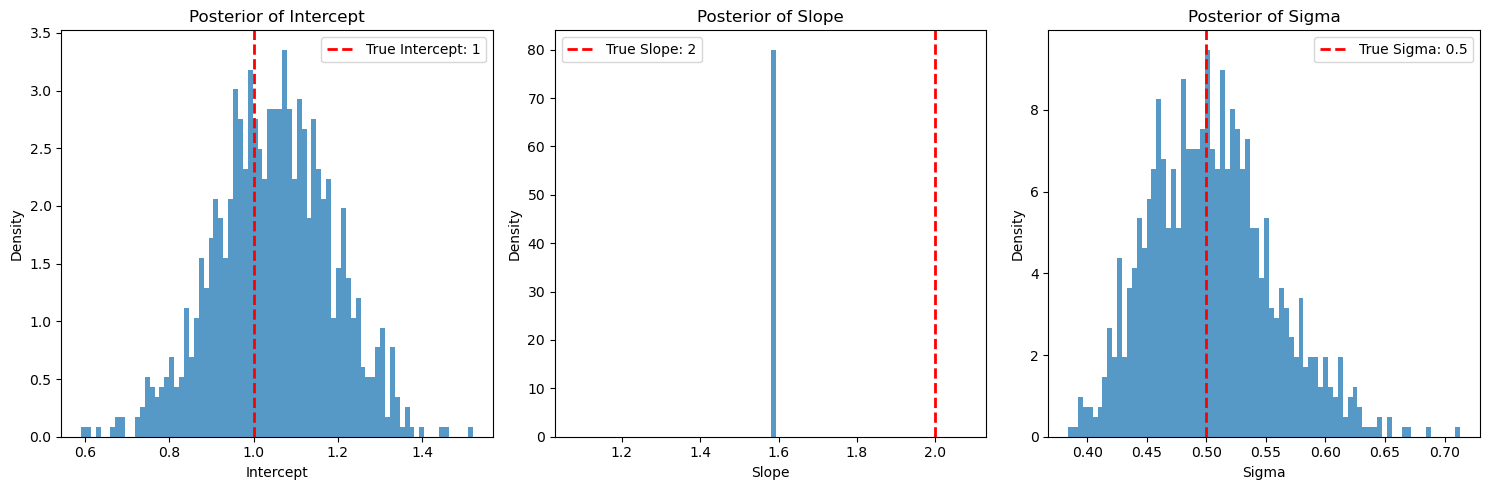

In [288]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot posterior for intercept
axes[0].hist(posterior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].axvline(
    TRUE_INTERCEPT,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Intercept: {TRUE_INTERCEPT}",
)
axes[0].set_title("Posterior of Intercept")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")
axes[0].legend()

# Plot posterior for slope
axes[1].hist(posterior_samples["slopes"][0], bins=80, density=True, alpha=0.75)
axes[1].axvline(
    TRUE_SLOPES[0],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Slope: {TRUE_SLOPES[0]}",
)
axes[1].set_title("Posterior of Slope")
axes[1].set_xlabel("Slope")
axes[1].set_ylabel("Density")
axes[1].legend()

# Plot posterior for sigma
axes[2].hist(posterior_samples["noise"], bins=80, density=True, alpha=0.75)
axes[2].axvline(
    TRUE_SIGMA,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Sigma: {TRUE_SIGMA}",
)
axes[2].set_title("Posterior of Sigma")
axes[2].set_xlabel("Sigma")
axes[2].set_ylabel("Density")
axes[2].legend()

plt.tight_layout()
plt.show()

In [289]:
bayes_model.get_posterior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.048,0.137,0.794,1.311,0.006,0.005,467.0,253.0,NaN
slopes[feature1],1.894,0.264,1.414,2.387,0.012,0.009,450.0,373.0,NaN
noise_var,0.257,0.053,0.171,0.363,0.002,0.002,499.0,660.0,NaN
noise,0.505,0.051,0.413,0.602,0.002,0.002,499.0,660.0,NaN


Additionally, note that apart from using the convenience functions provided by the BayesianLinearRegressor, such as `get_posterior_summary`, you can directly access the `trace` attribute of the model instance. This `trace` object contains the samples generated by the MCMC algorithms, capturing the posterior distribution of the model parameters.

Once you have the `trace` object, you can use the `arviz` library to analyze and visualize any distributions created during the model's lifetime, such as the prior and posterior distributions. `arviz` provides a rich set of tools for diagnostics, plotting, and summarizing the results of Bayesian models. This allows for a thorough examination of the model's behavior and the reliability of the inferred parameters.

For example, here, we use `arviz`'s `plot_posterior` to plot the posterior distribution of the `intercept ` variable.

<Axes: title={'center': 'intercept'}>

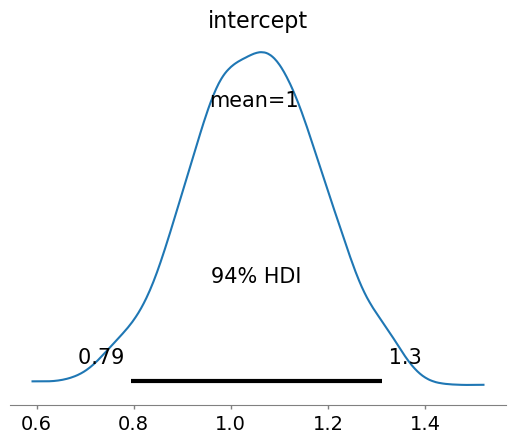

In [290]:
az.plot_posterior(bayes_model.idata, var_names="intercept")

# Model checking



Before using our Bayesian model to make predictions, it is advisable to perform some sanity checks to ascertain the correctness of the model set up and the assumptions. This section describes some of the most commonly used checks.

## `graphviz` Visualization

One way to understand the `bayes_model` is to visualize its composition using the `.visualize_model` method. This method uses the `graphviz` library to generate a graphical representation of the model, illustrating the relationships and dependencies between the priors, likelihood, data and the posterior.


The graphviz diagram will show the following:

- Ovals indicate stochastic nodes (random variables).
- Rectangles represent deterministic nodes (computed values).
- Shaded shapes (like the shaded ovals for X and y) indicate observed data or fixed inputs.
- Unshaded shapes represent latent variables or parameters that the model is trying to infer.

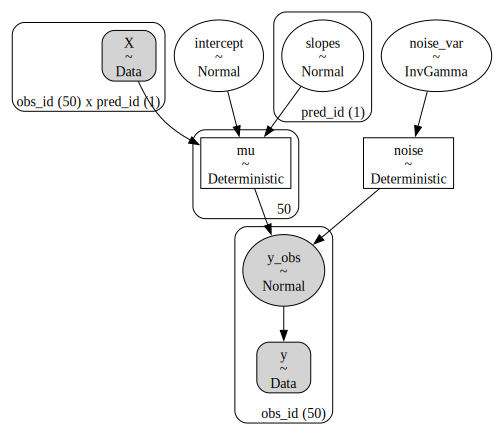

In [291]:
bayes_model.visualize_model()

## Posterior Predictive Check


A posterior predictive check (PPC) is a method used in Bayesian statistics to assess the fit of a model by comparing observed data to data simulated from the model. It involves generating new data sets from the posterior distribution of the model parameters and comparing these to the actual observed data. This process helps to identify discrepancies between the model predictions and the observed data, thereby providing a way to evaluate the adequacy of the model.

The `BayesianLinearRegressor` class provides a convenient method, `plot_ppc` to visually perform PPC.

The resulting plot will show the following components:

1. **Blue Lines**: represent the posterior predictive samples, which are the range of possible values that the model predicts for the observed data, given the posterior distribution of the parameters.

2. **Black Line**: represents the density of the observed data values, i.e. the actual distribution of the data.

3. **Orange Dashed Line**: represents the mean of the posterior predictive distribution, whichprovides a central tendency of the model's predictions.

The plot is used to visually assess the goodness of fit of the Bayesian model. By comparing the observed data distribution (black line) to the posterior predictive samples (blue lines) and their mean (orange dashed line), we can see if there are significant discrepancies. If the observed data closely follows the central tendency and falls within the range of the posterior predictive samples (like what we see in the plot below), it suggests that the model fits the data well.


<Axes: xlabel='y_obs'>

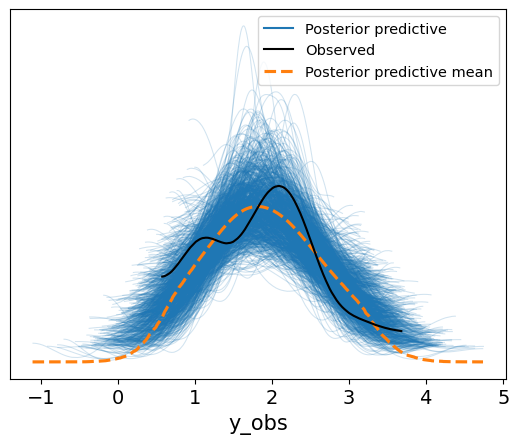

In [294]:
bayes_model.plot_ppc()

# Predictions

Now, it's time to use the trained `bayes_model` to perform out-of-sample prediction. As mentioned earlier, a significant benefit of using the Bayesian model is that it generates a full distribution for each test data point, rather than a single point estimate. This provides a more comprehensive understanding of the uncertainty and variability in the predictions.

In our class, this is accomplished using the `predict_proba` method, which returns an `skpro` `Empirical` distribution.


## `predict_proba`

In [304]:
y_pred_proba_bayes = bayes_model.predict_proba(X_test)

Sampling: [y_obs]


Output()

The returned distribution is known as the **posterior predictive distribution**. This distribution provides probabilistic forecasts for future observations by incorporating uncertainty about the model parameters and data variability.

The posterior predictive distribution enables us to make probabilistic statements about future observations and understand the variability in our predictions.



The posterior predictive distribution is given by:

$$
p(y_{\text{pred}} \mid X_{\text{new}}, X_{\text{train}}, y_{\text{train}}) = \int p(y_{\text{pred}} \mid X_{\text{new}}, \theta) p(\theta \mid X_{\text{train}}, y_{\text{train}}) \, d\theta
$$

where:
- $y_{\text{pred}}$ is the new predicted data point.
- $X_{\text{new}}$ is the new input.
- $\mathbf{X}_{\text{train}}$ is the set of observed inputs.
- $\mathbf{y}_{\text{train}}$ is the set of observed outputs.
- $\mathbf{\theta}$ represents the model parameters.
- $p(y_{\text{pred}} | X_{\text{new}}, \mathbf{\theta})$ is the likelihood of the new data point given the model parameters.
- $p(\mathbf{\theta} | \mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$ is the posterior distribution of the model parameters given the observed data.

The above equation states that to obtain the distribution of the predictions $y_{\text{pred}}$, we need to perform two iterative sampling:

1. First, we sample from the posterior distribution $p(\theta \mid X_{\text{train}}, y_{\text{train}})$**

2. Afterwards, for each sampled $\theta$ from the posterior, we sample $y_{\text{pred}}$ from the predictive distribution $p(y_{\text{pred}} \mid X_{\text{new}}, \theta)$.

In practice, PyMC conveniently handles this sequential sampling process for us.

## `predict`

If point predictions are what we're after, we've got the `predict` method to do so. Internally, this `predict` method calls the `predict_proba` method above and averages the resulting posterior predictive distribution to provide a single point estimate for each test data point.

In [305]:
y_pred_bayes = bayes_model.predict(X_test)
y_pred_bayes.tail()

Sampling: [y_obs]


Output()

,target
obs_id,
25,2.695099
26,2.738434
27,2.832156
28,2.867218
29,2.957238


## `predict_quantiles`

The advantage of obtaining a full predictive distribution for our test set is that we can quantify our uncertainty by calculating quantiles. This can be conveniently achieved using the `predict_quantiles` method. Here, we use `predict_quantiles` to get the 25-th and 75-th percentiles of the posterior predictive distributions.

We'll then use these quantiles to plot our predictions together with their uncertainty.


In [306]:
y_pred_bayes_quantiles = bayes_model.predict_quantiles(X_test, [0.25, 0.75])
y_pred_bayes_quantiles.head()

Sampling: [y_obs]


Output()

target          
            0.25      0.75
obs_id                    
0       0.699875  1.400261
1       0.749735  1.461532
2       0.789835  1.512907
3       0.940880  1.603275
4       0.989187  1.642544

## `predict_interval`

Lastly, the model comes with the `predict_interval` method. This method returns the **credible interval**, which is a range within which a certain proportion of the posterior distribution lies. For example, a 95% credible interval for a parameter $\theta$ means that there is a 95% probability that $\theta$ lies within this interval, given the observed data and the prior distribution.

In [307]:
y_pred_bayes_interval = bayes_model.predict_interval(X_test, 0.95)
y_pred_bayes_interval.head()

Sampling: [y_obs]


Output()

target          
            0.95          
           lower     upper
obs_id                    
0       0.024700  2.117168
1       0.086801  2.128516
2       0.062616  2.270406
3       0.225289  2.210461
4       0.331629  2.230350

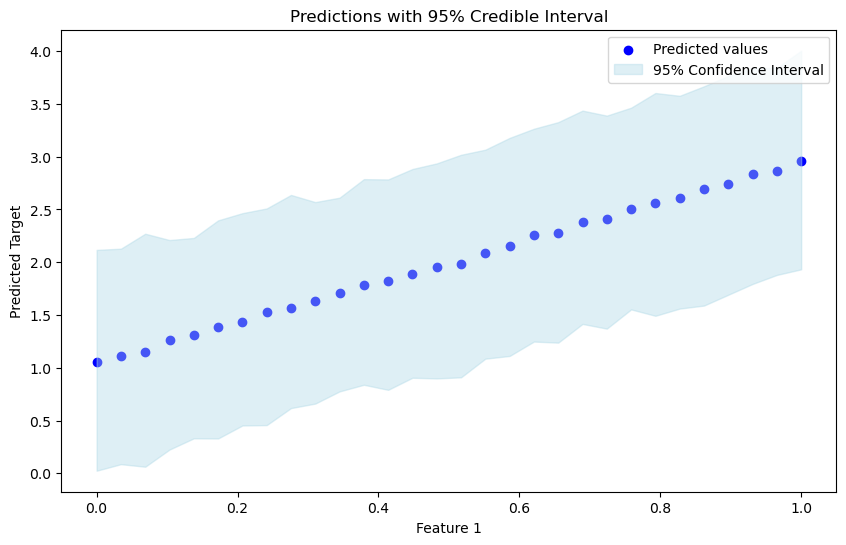

In [308]:
# Plot the predictions with the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test["feature1"], y_pred_bayes, color="blue", label="Predicted values")
plt.fill_between(
    X_test["feature1"],
    y_pred_bayes_interval["target"][0.95]["lower"],
    y_pred_bayes_interval["target"][0.95]["upper"],
    color="lightblue",
    alpha=0.4,
    label="95% Confidence Interval",
)
plt.xlabel("Feature 1")
plt.ylabel("Predicted Target")
plt.title("Predictions with 95% Credible Interval")
plt.legend()
plt.show()

# Effect of Sample Size

Lastly, let's take a look at how the size of training sample affects the width of the posteriors and posterior predictive distributions.

## Posterior

In [309]:
bayes_model.get_posterior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.048,0.137,0.794,1.311,0.006,0.005,467.0,253.0,NaN
slopes[feature1],1.894,0.264,1.414,2.387,0.012,0.009,450.0,373.0,NaN
noise_var,0.257,0.053,0.171,0.363,0.002,0.002,499.0,660.0,NaN
noise,0.505,0.051,0.413,0.602,0.002,0.002,499.0,660.0,NaN


Now, let's generate a synthetic dataset with 500 datapoints and use it to train another model.

In [310]:
N = 500

# Creating 500 random data points containing 1 feature
feature1 = np.random.uniform(0, 1, N)
X_train = pd.DataFrame({"feature1": feature1})

# Set the relationship between the feature and the target variable
TRUE_INTERCEPT = 1
TRUE_SLOPES = np.array([2])
TRUE_SIGMA = 0.5

# Calculating the true target variable
y_true = TRUE_INTERCEPT + np.dot(X_train, TRUE_SLOPES)
y_train = y_true + np.random.normal(0, TRUE_SIGMA, size=len(X_train))

bayes_model_500 = BayesianLinearRegressor()
bayes_model_500.fit(X_train, y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=0, sigma=10),
                                      'noise_var': Prior("InverseGamma", alpha=1, beta=1),
                                      'slopes': Prior("Normal", mu=0, sigma=10, dims="pred_id")},
                        sampler_config={'chains': 1, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

We see that with this 10x increase in training set size, we obtain narrower posteriors, as evidenced by the lower `sd` values in the summary. It is noteworthy that the reduction of the standard deviation, which is around 3x, is less than the 10x reduction one might expect.

In [311]:
bayes_model_500.get_posterior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.054,0.047,0.969,1.138,0.003,0.002,312.0,291.0,NaN
slopes[feature1],1.914,0.085,1.762,2.077,0.005,0.003,326.0,211.0,NaN
noise_var,0.244,0.016,0.217,0.276,0.001,0.001,390.0,431.0,NaN
noise,0.494,0.016,0.466,0.526,0.001,0.001,390.0,431.0,NaN


In [312]:
bayes_model.get_posterior_summary() / bayes_model_500.get_posterior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.994307,2.914894,0.819401,1.152021,2.0,2.5,1.496795,0.869416,NaN
slopes[feature1],0.989551,3.105882,0.802497,1.149254,2.4,3.0,1.380368,1.767773,NaN
noise_var,1.053279,3.312500,0.788018,1.315217,2.0,2.0,1.279487,1.531323,NaN
noise,1.022267,3.187500,0.886266,1.144487,2.0,2.0,1.279487,1.531323,NaN


## Posterior Predictive

Now, let's perform the same experiment, this time comparing the posterior predictive distribution coming from the two models.

In order to get the posterior predictive distribution from the second model (`bayes_model_500`), we first need to use it to perform prediction on the test set.

In [313]:
y_pred_proba_bayes_500 = bayes_model_500.predict_proba(X_test)

Sampling: [y_obs]


Output()

With that out of the way, let's now compare the posterior predictive distributions for both models.

In [314]:
az.summary(bayes_model.idata.predictions)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],1.057,0.533,0.008,1.988,0.019,0.013,832.0,906.0,NaN
y_obs[1],1.110,0.513,0.181,2.101,0.016,0.012,1032.0,875.0,NaN
y_obs[2],1.152,0.545,0.059,2.117,0.016,0.012,1112.0,901.0,NaN
y_obs[3],1.259,0.505,0.327,2.218,0.017,0.012,882.0,872.0,NaN
y_obs[4],1.314,0.499,0.340,2.173,0.016,0.011,1010.0,825.0,NaN
y_obs[5],1.390,0.524,0.411,2.326,0.017,0.012,1010.0,983.0,NaN
y_obs[6],1.431,0.505,0.499,2.393,0.017,0.012,922.0,839.0,NaN
y_obs[7],1.525,0.527,0.575,2.518,0.018,0.013,843.0,892.0,NaN
y_obs[8],1.567,0.530,0.634,2.576,0.017,0.012,910.0,1060.0,NaN
y_obs[9],1.629,0.498,0.763,2.579,0.016,0.012,955.0,877.0,NaN


In [315]:
az.summary(bayes_model_500.idata.predictions)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],1.063,0.493,0.065,1.956,0.016,0.011,993.0,844.0,NaN
y_obs[1],1.108,0.498,0.121,1.986,0.016,0.012,967.0,944.0,NaN
y_obs[2],1.182,0.496,0.167,2.007,0.016,0.011,1001.0,994.0,NaN
y_obs[3],1.229,0.492,0.381,2.288,0.016,0.011,926.0,951.0,NaN
y_obs[4],1.333,0.515,0.315,2.272,0.018,0.013,832.0,820.0,NaN
y_obs[5],1.408,0.491,0.501,2.339,0.016,0.011,1000.0,944.0,NaN
y_obs[6],1.445,0.500,0.498,2.407,0.016,0.012,937.0,884.0,NaN
y_obs[7],1.509,0.483,0.655,2.428,0.017,0.012,842.0,944.0,NaN
y_obs[8],1.568,0.506,0.632,2.504,0.017,0.012,848.0,876.0,NaN
y_obs[9],1.626,0.494,0.803,2.669,0.016,0.011,1004.0,979.0,NaN


We see that there is practically no difference in the standard deviation of the posterior predictive of both models.

In [316]:
(
    az.summary(bayes_model_500.idata.predictions)
    / az.summary(bayes_model.idata.predictions)
)[["sd"]]

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,sd
y_obs[0],0.924953
y_obs[1],0.970760
y_obs[2],0.910092
y_obs[3],0.974257
y_obs[4],1.032064
y_obs[5],0.937023
y_obs[6],0.990099
y_obs[7],0.916509
y_obs[8],0.954717
y_obs[9],0.991968


# References

(WIP)

https://discourse.pymc.io/t/how-to-use-the-posterior-predictive-distribution-for-checking-a-model-from-pymc/11593/9

https://www.pymc.io/projects/docs/en/v5.15.1/api/generated/pymc.sample_prior_predictive.html

https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf